In [ ]:
# -*- coding:utf-8 -*-

import tensorflow as tf

# training data set
x_data = [[73, 80, 75],
          [93, 88, 93],
          [89, 91, 90],
          [96, 98, 100],
          [73, 66, 70]]

y_data = [[152],
          [185],
          [180],
          [196],
          [142]]

# placeholder 생성 (tensorflow에서 계산을 하기 위한 그래프를 그릴때 입력으로 사용되는 node)
# shape=[5, 3] -> [None, 3] (행은 생각하지 않겠다. 어떤 형태이든 상관없음)
X = tf.placeholder(shape=[None, 3], dtype=tf.float32)
Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random_normal([3, 1]), name='weight')
b = tf.Variable(tf.random_normal([1]), name='bias')

# 우리의 목적은 Hypothesis (Prediction Model) 만드는 것
# H = W * X + b
H = tf.matmul(X, W) + b

# cost function (loss function)
# Linear Regression 의 cost 함수
cost = tf.reduce_mean(tf.square(H-Y))

# train node
train = tf.train.GradientDescentOptimizer(learning_rate=0.00001).minimize(cost)

# session과 초기화 작업
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 학습 (epoch = 3000)
for step in range(3000):
    _, cost_val = sess.run([train, cost], feed_dict={X: x_data, Y: y_data})

    if step % 300 == 0:
        print('cost : {}'.format(cost_val))

# prediction
predict = sess.run(H, feed_dict={X: [[90, 95, 50]]})
print('예측값 : {}'.format(predict))


0.087


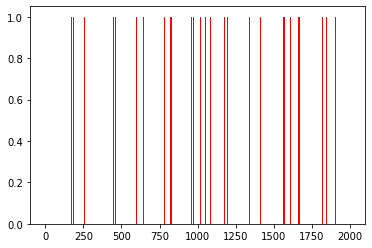

In [2]:
# -*- coding:utf-8 -*-

import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# 입력 shape을 맞춰주기 위한 one_hot_encoding function
def one_hot(x):
    # frozen lake state 개수가 16개라서
    return np.identity(16)[x: x+1]


# environment 생성
env = gym.make('FrozenLake-v0')

# input size (state), output size(action)
# state 개수 : 16
input_size = env.observation_space.n
# action 개수 : 4
output_size = env.action_space.n

#####
# Q function (Q table)을 대신할 Hypothesis (tensorflow를 사용하여 계산)
# tensorflow graph = predict model
# 1. placeholder
X = tf.placeholder(shape=[1, input_size], dtype=tf.float32)
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)

# 2. Weight & bias -> Weight 값만 구한다 (b를 빼고 간소화함)
# random_uniform(입력, 평균, 표준편차) : 정규분표로 난수를 구한다.
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))

# 3. Hypothesis (Q의 prediction 역할)
Q_predict = tf.matmul(X, W)

# 4. 학습
# cost function (loss function)
# 왜 sum? -> 평균보다 sum이 더 좋더라 (경험적)
cost = tf.reduce_sum(tf.square(Q_predict-Y))

# train
# learning rate는 경험적으로 바꿔가며 적합한 값을 찾아야 한다.
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

# session 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#####

# Reinforcement Learning parameter
dis = 0.95
# episode = epoch (강화학습의 예측모델로 linear 가 들어온 것이니, episode 라고 말하는 것이 맞다.)
num_of_episode = 2000
# 최종 성공 확률을 계산하기 위한 list
reward_list = []

for i in range(num_of_episode):
    state = env.reset()
    reward_all = 0
    e = 0.1 / (i+1)
    done = False

    while not done:
        # state 에서 Q function (H) 에게 물어본다.
        Q_state = sess.run(Q_predict, feed_dict={X: one_hot(state)})

        # action 선택
        if np.random.rand(1) < e:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_state)

        # step
        new_state, reward, done, _ = env.step(action)

        if done:
            # 예측한 것을 상황에 맞게 수정해야 한다.
            # Linear Regression은 Y값이 무조건 필요하기 때문 (Q_state 를 나중에 Y 값으로 사용할 것임)
            Q_state[0, action] = reward
        else:
            # Q(s, a) = r + dis * maxQ(s', a')
            next_Q_state = sess.run(Q_predict, feed_dict={X: one_hot(new_state)})
            Q_state[0, action] = reward + dis * np.max(next_Q_state)

        # Y측 레이블에 '정답' 이라고 간주할 값이 있어야 학습할 수 있어서 위의 작업을 했다.
        sess.run(train, feed_dict={X: one_hot(state), Y: Q_state})

        reward_all += reward
        state = new_state

    reward_list.append(reward_all)

print(sum(reward_list) / num_of_episode)

plt.bar(range(len(reward_list)), reward_list, color='red')
plt.show()
